In [1]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [2]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [3]:
class ImageTransform():

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)), 
                transforms.RandomHorizontalFlip(), 
                transforms.ToTensor(), 
                transforms.Normalize(mean, std)  
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  
                transforms.CenterCrop(resize),  
                transforms.ToTensor(),  
                transforms.Normalize(mean, std) 
            ])
        }

    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)


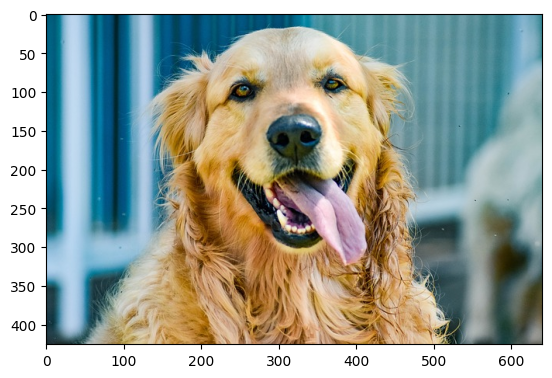

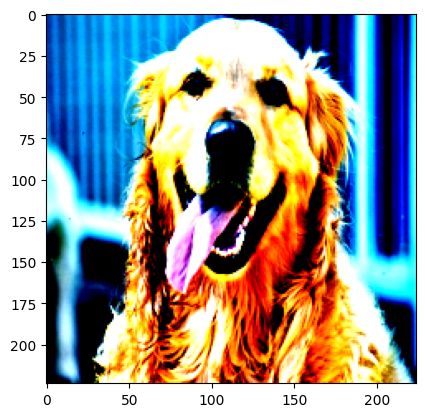

In [7]:
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)   

plt.imshow(img)
plt.show()

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])

img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [8]:
def make_datapath_list(phase="train"):
    
    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)

    path_list = [] 

    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list


train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

train_list


./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train\\ants\\0013035.jpg',
 './data/hymenoptera_data/train\\ants\\1030023514_aad5c608f9.jpg',
 './data/hymenoptera_data/train\\ants\\1095476100_3906d8afde.jpg',
 './data/hymenoptera_data/train\\ants\\1099452230_d1949d3250.jpg',
 './data/hymenoptera_data/train\\ants\\116570827_e9c126745d.jpg',
 './data/hymenoptera_data/train\\ants\\1225872729_6f0856588f.jpg',
 './data/hymenoptera_data/train\\ants\\1262877379_64fcada201.jpg',
 './data/hymenoptera_data/train\\ants\\1269756697_0bce92cdab.jpg',
 './data/hymenoptera_data/train\\ants\\1286984635_5119e80de1.jpg',
 './data/hymenoptera_data/train\\ants\\132478121_2a430adea2.jpg',
 './data/hymenoptera_data/train\\ants\\1360291657_dc248c5eea.jpg',
 './data/hymenoptera_data/train\\ants\\1368913450_e146e2fb6d.jpg',
 './data/hymenoptera_data/train\\ants\\1473187633_63ccaacea6.jpg',
 './data/hymenoptera_data/train\\ants\\148715752_302c84f5a4.jpg',
 './data/hymenoptera_data/train\\ants\\1489674356_09d48dde0a.jpg',
 './data/hym

In [9]:
class HymenopteraDataset(data.Dataset):

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list 
        self.transform = transform 
        self.phase = phase  

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):


        img_path = self.file_list[index]
        img = Image.open(img_path)

        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]

        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1

        return img_transformed, label


train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])


torch.Size([3, 224, 224])
0


In [10]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

batch_iterator = iter(dataloaders_dict["train"]) 
inputs, labels = next(
    batch_iterator)  
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 1, 1, 1])


In [11]:
use_pretrained = True
vgg16 = models.vgg16(pretrained=use_pretrained)

# 마지막 계층을 2개의 클래스가 나오도록 세팅
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=2)

vgg16.train()


C:\Users\admin\Anaconda3\envs\torch2_lab\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\admin\Anaconda3\envs\torch2_lab\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
criterion = nn.CrossEntropyLoss()

In [14]:
params_to_update = []

update_param_names = ["classifier.6.weight", "classifier.6.bias"]

for name, param in vgg16.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

print("-----------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
-----------
[Parameter containing:
tensor([[ 0.0003, -0.0142,  0.0154,  ...,  0.0097,  0.0040,  0.0110],
        [-0.0065, -0.0104,  0.0063,  ...,  0.0031, -0.0010, -0.0089]],
       requires_grad=True), Parameter containing:
tensor([ 0.0033, -0.0101], requires_grad=True)]


In [18]:
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)


In [19]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() 
            else:
                net.eval()  

            epoch_loss = 0.0 
            epoch_corrects = 0 

            if (epoch == 0) and (phase == 'train'):
                continue

            for inputs, labels in tqdm(dataloaders_dict[phase]):

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) 
                    _, preds = torch.max(outputs, 1)
                    
  
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()


                    epoch_loss += loss.item() * inputs.size(0)  
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

In [21]:
num_epochs=2
train_model(vgg16, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/2
-------------


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.38s/it]


val Loss: 0.6859 Acc: 0.5882
Epoch 2/2
-------------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:18<00:00,  2.33s/it]


train Loss: 0.4857 Acc: 0.7778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.34s/it]

val Loss: 0.2188 Acc: 0.9281
